<a href="https://colab.research.google.com/github/msamwelmollel/ML-CLUB-2024-Eagle-Labs/blob/main/ML_CLUB_2024_Eagle_Labs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install -qU langchain langchain-openai langchain-mongodb langchain-experimental ragas pymongo tqdm chromadb

In [1]:
# from google.colab import files

# uploaded = files.upload()


In [2]:
# from IPython.display import Image

# # Display the image with a specific width and height
# Image('RAG.jpeg', width=600, height=400)

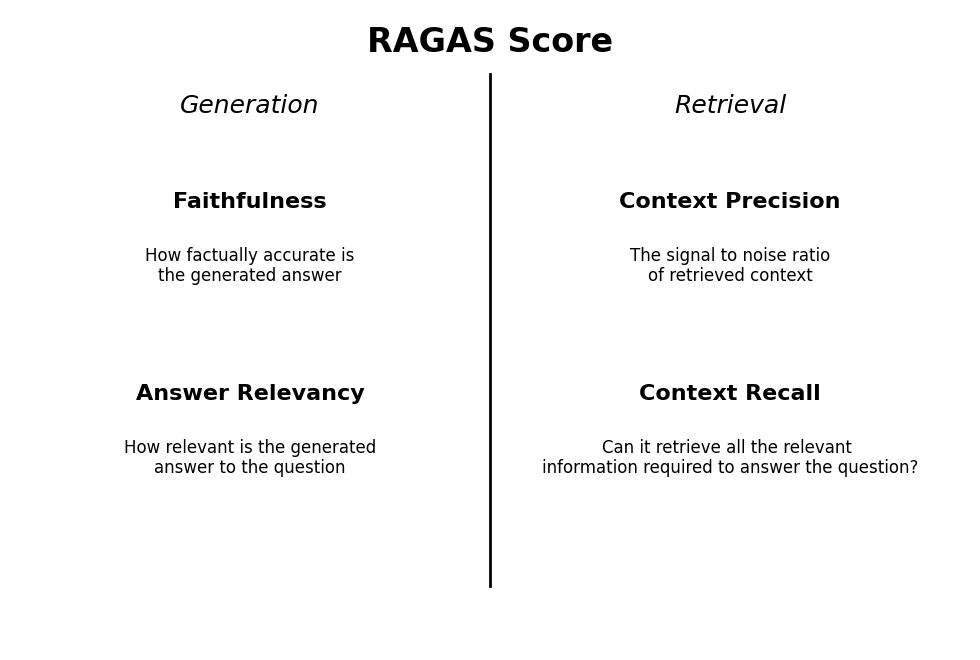

In [43]:
# @title RAGAS
import matplotlib.pyplot as plt

def create_ragas_plot():
    # Create figure and axis
    fig, ax = plt.subplots(figsize=(12, 8))

    # Remove axes
    ax.axis('off')

    # Add title
    ax.text(0.5, 0.95, 'RAGAS Score', ha='center', va='center', fontsize=24, fontweight='bold')

    # Add vertical line
    ax.axvline(x=0.5, ymin=0.1, ymax=0.9, color='black', linewidth=2)

    # Add subtitles
    ax.text(0.25, 0.85, 'Generation', ha='center', va='center', fontsize=18, fontstyle='italic')
    ax.text(0.75, 0.85, 'Retrieval', ha='center', va='center', fontsize=18, fontstyle='italic')

    # Add components and descriptions with better positioning and wrapping
    components = [
        ('Faithfulness', 'How factually accurate is\nthe generated answer', 0.25, 0.7),
        ('Context Precision', 'The signal to noise ratio\nof retrieved context', 0.75, 0.7),
        ('Answer Relevancy', 'How relevant is the generated\nanswer to the question', 0.25, 0.4),
        ('Context Recall', 'Can it retrieve all the relevant \ninformation required to answer the question?', 0.75, 0.4)
    ]

    for component, description, x, y in components:
        ax.text(x, y, component, ha='center', va='center', fontsize=16, fontweight='bold')
        ax.text(x, y-0.1, description, ha='center', va='center', fontsize=12, wrap=True)

    # Display the plot
    plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)
    plt.show()

# Call the function to create the plot
create_ragas_plot()


In [5]:
from google.colab import userdata
OPENAI_API_KEY = userdata.get('OPENAI_API_KEY')

In [6]:
import os
from openai import OpenAI
os.environ["OPENAI_API_KEY"] = OPENAI_API_KEY # getpass.getpass("Enter your OpenAI API Key:")
openai_client = OpenAI()

In [7]:
from langchain_community.document_loaders import WebBaseLoader

web_loader = WebBaseLoader(
    [
        "https://peps.python.org/pep-0483/",
        "https://peps.python.org/pep-0008/",
        "https://peps.python.org/pep-0257/",
    ]
)

pages = web_loader.load()

In [8]:
# Document = pages

In [9]:
# x= Document(
#     page_content="\nThe goal of this PEP is to propose such a systematic way of defining types\nfor type annotations of variables and functions using PEP 3107 syntax.",
#     metadata= {'source': 'https://peps.python.org/pep-0483/', 'title': 'PEP 483 – The Theory of Type Hints | peps.python.org', 'description': 'Python Enhancement Proposals (PEPs)', 'language': 'en'}
# )

In [10]:
from typing import List, Optional
from langchain.schema import Document  # Assuming Document is from langchain.schema

In [11]:
from langchain.text_splitter import TokenTextSplitter

def fixed_token_split(
    docs: List[Document], chunk_size: int, chunk_overlap: int
) -> List[Document]:
    """
    Fixed token chunking

    Args:
        docs (List[Document]): List of documents to chunk
        chunk_size (int): Chunk size (number of tokens)
        chunk_overlap (int): Token overlap between chunks

    Returns:
        List[Document]: List of chunked documents
    """
    splitter = TokenTextSplitter(
        encoding_name="cl100k_base", chunk_size=chunk_size, chunk_overlap=chunk_overlap
    )
    return splitter.split_documents(docs)

In [12]:
from langchain.text_splitter import (
    Language,
    RecursiveCharacterTextSplitter,
)

def recursive_split(
    docs: List[Document],
    chunk_size: int,
    chunk_overlap: int,
    language: Optional[Language] = None,
) -> List[Document]:
    """
    Recursive chunking

    Args:
        docs (List[Document]): List of documents to chunk
        chunk_size (int): Chunk size (number of tokens)
        chunk_overlap (int): Token overlap between chunks
        language (Optional[Language], optional): Programming language enum. Defaults to None.

    Returns:
        List[Document]: List of chunked documents
    """
    separators = ["\n\n", "\n", " ", ""]

    if language is not None:
        try:
            separators = RecursiveCharacterTextSplitter.get_separators_for_language(
                language
            )
        except (NameError, ValueError) as e:
            print(f"No separators found for language {language}. Using defaults.")

    splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
        encoding_name="cl100k_base",
        chunk_size=chunk_size,
        chunk_overlap=chunk_overlap,
        separators=separators,
    )
    return splitter.split_documents(docs)

In [13]:
from langchain_experimental.text_splitter import SemanticChunker
from langchain_openai.embeddings import OpenAIEmbeddings

def semantic_split(docs: List[Document]) -> List[Document]:
    """
    Semantic chunking

    Args:
        docs (List[Document]): List of documents to chunk

    Returns:
        List[Document]: List of chunked documents
    """
    splitter = SemanticChunker(
        OpenAIEmbeddings(), breakpoint_threshold_type="percentile"
    )
    return splitter.split_documents(docs)

In [14]:
from ragas import RunConfig
from ragas.testset.generator import TestsetGenerator
from ragas.testset.evolutions import simple, reasoning, multi_context
from langchain_openai import ChatOpenAI, OpenAIEmbeddings

RUN_CONFIG = RunConfig(max_workers=4, max_wait=180)

# generator with openai models
generator_llm = ChatOpenAI(model="gpt-3.5-turbo-16k")
critic_llm = ChatOpenAI(model="gpt-4o")
embeddings = OpenAIEmbeddings()

generator = TestsetGenerator.from_langchain(generator_llm, critic_llm, embeddings)

# Change resulting question type distribution
distributions = {simple: 0.4, multi_context: 0.4, reasoning: 0.2}

testset = generator.generate_with_langchain_docs(
    pages, 10, distributions, run_config=RUN_CONFIG
)

embedding nodes:   0%|          | 0/46 [00:00<?, ?it/s]

Generating:   0%|          | 0/10 [00:00<?, ?it/s]

In [15]:
# questions = [item.question for item in testset.test_data]
# ground_truths = [item.ground_truth for item in testset.test_data]
# questions

In [16]:
import pandas as pd
from langchain_community.vectorstores import Chroma
from langchain_openai import OpenAIEmbeddings
from langchain_core.documents import Document
from typing import List, Dict
from tqdm import tqdm
from datasets import Dataset
from ragas import evaluate
from ragas.metrics import context_precision, context_recall
import nest_asyncio

# Allow nested use of asyncio (used by Ragas)
nest_asyncio.apply()

# Disable tqdm locks
tqdm.get_lock().locks = []

# Assuming testset is already defined
QUESTIONS = [item.question for item in testset.test_data]
GROUND_TRUTH = [item.ground_truth for item in testset.test_data]

def create_vector_store(docs: List[Document]) -> Chroma:
    embedding_function = OpenAIEmbeddings(model="text-embedding-3-small")
    return Chroma.from_documents(
        documents=docs,
        embedding=embedding_function,
        collection_name="chunking_evaluation"
    )

def perform_eval(docs: List[Document]) -> Dict[str, float]:
    eval_data = {
        "question": QUESTIONS,
        "ground_truth": GROUND_TRUTH,
        "contexts": [],
    }

    print("Creating new Chroma vector store")
    vector_store = create_vector_store(docs)

    print("Getting contexts for evaluation set")
    for question in tqdm(QUESTIONS):
        eval_data["contexts"].append(
            [doc.page_content for doc in vector_store.similarity_search(question, k=3)]
        )

    dataset = Dataset.from_dict(eval_data)

    print("Running evals")
    result = evaluate(
        dataset=dataset,
        metrics=[context_precision, context_recall],
        run_config=RUN_CONFIG,
        raise_exceptions=False,
    )
    return result


In [17]:
import json
import nltk
from typing import List
from langchain.schema import Document

def ai_based_split(docs: List[Document]) -> List[Document]:
    """
    AI-based chunking strategy

    Args:
        docs (List[Document]): List of documents to chunk

    Returns:
        List[Document]: List of chunked documents
    """
    nltk.download('punkt', quiet=True)
    chunked_docs = []

    for doc in docs:
        text = doc.page_content
        sentences = nltk.sent_tokenize(text)
        text_with_artifacts = ""
        for i, sentence in enumerate(sentences):
            text_with_artifacts += f"{sentence} [{i}]\n"

        response = openai_client.chat.completions.create(
            model="gpt-4o-mini",
            messages=[
                {"role": "system", "content": "You are an AI assistant tasked with chunking a text into cohesive sections."},
                {"role": "user", "content": f"Determine the best chunks by specifying start and end artifact numbers. Make the chunks as large as possible while maintaining coherence. Provide a context for each chunk. Ensure no overlap between chunks, and no gaps. Return the result as a JSON array of objects, each with 'start', 'end', and 'context' fields. Here's the text:\n\n{text_with_artifacts}"}
            ],
            response_format={"type": "json_object"}
        )

        try:
            chunks = json.loads(response.choices[0].message.content)
            # Check if 'chunks' is a key in the response, if not, assume the whole response is the chunks list
            if isinstance(chunks, dict) and 'chunks' in chunks:
                chunks = chunks['chunks']
            elif not isinstance(chunks, list):
                raise ValueError("Unexpected response format")

            for chunk in chunks:
                chunk_text = " ".join(sentences[chunk['start']:chunk['end']+1])
                chunked_docs.append(Document(
                    page_content=chunk_text,
                    metadata={
                        **doc.metadata,
                        "chunk_start": chunk['start'],
                        "chunk_end": chunk['end'],
                        "chunk_context": chunk['context']
                    }
                ))
        except json.JSONDecodeError:
            print(f"Error decoding JSON response: {response.choices[0].message.content}")
        except KeyError as e:
            print(f"Missing key in chunk: {e}")
        except Exception as e:
            print(f"Error processing chunks: {e}")

    return chunked_docs

# Update the evaluation loop
results = []

for chunking_strategy in ["AI-based chunking", "Fixed token without overlap", "Fixed token with overlap", "Recursive with overlap", "Recursive Python splitter with overlap"]:
    if chunking_strategy != "AI-based chunking":
        for chunk_size in [100, 200, 500, 1000]:
            chunk_overlap = int(0.15 * chunk_size)
            print(f"Evaluating: {chunking_strategy} - Chunk Size: {chunk_size}")

            if chunking_strategy == "Fixed token without overlap":
                result = perform_eval(fixed_token_split(pages, chunk_size, 0))
            elif chunking_strategy == "Fixed token with overlap":
                result = perform_eval(fixed_token_split(pages, chunk_size, chunk_overlap))
            elif chunking_strategy == "Recursive with overlap":
                result = perform_eval(recursive_split(pages, chunk_size, chunk_overlap))
            elif chunking_strategy == "Recursive Python splitter with overlap":
                result = perform_eval(recursive_split(pages, chunk_size, chunk_overlap, Language.PYTHON))

            results.append({
                "Chunking Strategy": chunking_strategy,
                "Chunk Size": chunk_size,
                "Context Precision": result['context_precision'],
                "Context Recall": result['context_recall']
            })
    else:
        print(f"Evaluating: {chunking_strategy}")
        result = perform_eval(ai_based_split(pages))
        results.append({
            "Chunking Strategy": chunking_strategy,
            "Chunk Size": "N/A",
            "Context Precision": result['context_precision'],
            "Context Recall": result['context_recall']
        })

# Evaluate semantic chunking (unchanged)
print("Evaluating: Semantic chunking")
result = perform_eval(semantic_split(pages))
results.append({
    "Chunking Strategy": "Semantic chunking",
    "Chunk Size": "N/A",
    "Context Precision": result['context_precision'],
    "Context Recall": result['context_recall']
})

# Create DataFrame and display results (unchanged)
df = pd.DataFrame(results)
print(df.to_string(index=False))

# Optionally, save to CSV (unchanged)
df.to_csv("chunking_evaluation_results.csv", index=False)

Evaluating: AI-based chunking
Creating new Chroma vector store
Getting contexts for evaluation set


100%|██████████| 10/10 [00:02<00:00,  4.69it/s]


Running evals


Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating: Fixed token without overlap - Chunk Size: 100
Creating new Chroma vector store
Getting contexts for evaluation set


100%|██████████| 10/10 [00:02<00:00,  4.78it/s]


Running evals


Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating: Fixed token without overlap - Chunk Size: 200
Creating new Chroma vector store
Getting contexts for evaluation set


100%|██████████| 10/10 [00:01<00:00,  5.06it/s]


Running evals


Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating: Fixed token without overlap - Chunk Size: 500
Creating new Chroma vector store
Getting contexts for evaluation set


100%|██████████| 10/10 [00:02<00:00,  4.94it/s]


Running evals


Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating: Fixed token without overlap - Chunk Size: 1000
Creating new Chroma vector store
Getting contexts for evaluation set


100%|██████████| 10/10 [00:02<00:00,  4.69it/s]


Running evals


Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating: Fixed token with overlap - Chunk Size: 100
Creating new Chroma vector store
Getting contexts for evaluation set


100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


Running evals


Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating: Fixed token with overlap - Chunk Size: 200
Creating new Chroma vector store
Getting contexts for evaluation set


100%|██████████| 10/10 [00:02<00:00,  3.72it/s]


Running evals


Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating: Fixed token with overlap - Chunk Size: 500
Creating new Chroma vector store
Getting contexts for evaluation set


100%|██████████| 10/10 [00:01<00:00,  5.12it/s]


Running evals


Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating: Fixed token with overlap - Chunk Size: 1000
Creating new Chroma vector store
Getting contexts for evaluation set


100%|██████████| 10/10 [00:02<00:00,  4.54it/s]


Running evals


Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating: Recursive with overlap - Chunk Size: 100
Creating new Chroma vector store
Getting contexts for evaluation set


100%|██████████| 10/10 [00:02<00:00,  4.79it/s]


Running evals


Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating: Recursive with overlap - Chunk Size: 200
Creating new Chroma vector store
Getting contexts for evaluation set


100%|██████████| 10/10 [00:02<00:00,  3.79it/s]

Running evals


Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating: Recursive with overlap - Chunk Size: 500
Creating new Chroma vector store
Getting contexts for evaluation set


100%|██████████| 10/10 [00:02<00:00,  4.83it/s]


Running evals


Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating: Recursive with overlap - Chunk Size: 1000
Creating new Chroma vector store
Getting contexts for evaluation set


100%|██████████| 10/10 [00:02<00:00,  4.58it/s]


Running evals


Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating: Recursive Python splitter with overlap - Chunk Size: 100
Creating new Chroma vector store
Getting contexts for evaluation set


100%|██████████| 10/10 [00:02<00:00,  4.30it/s]


Running evals


Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating: Recursive Python splitter with overlap - Chunk Size: 200
Creating new Chroma vector store
Getting contexts for evaluation set


100%|██████████| 10/10 [00:02<00:00,  4.86it/s]


Running evals


Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating: Recursive Python splitter with overlap - Chunk Size: 500
Creating new Chroma vector store
Getting contexts for evaluation set


100%|██████████| 10/10 [00:02<00:00,  4.06it/s]


Running evals


Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating: Recursive Python splitter with overlap - Chunk Size: 1000
Creating new Chroma vector store
Getting contexts for evaluation set


100%|██████████| 10/10 [00:05<00:00,  1.98it/s]


Running evals


Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating: Semantic chunking
Creating new Chroma vector store
Getting contexts for evaluation set


100%|██████████| 10/10 [00:02<00:00,  4.99it/s]


Running evals


Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

                     Chunking Strategy Chunk Size  Context Precision  Context Recall
                     AI-based chunking        N/A           0.833333        0.683333
           Fixed token without overlap        100           0.900000        0.653333
           Fixed token without overlap        200           0.800000        0.659167
           Fixed token without overlap        500           0.850000        0.600833
           Fixed token without overlap       1000           0.775000        0.630833
              Fixed token with overlap        100           0.825000        0.617500
              Fixed token with overlap        200           0.766667        0.667500
              Fixed token with overlap        500           0.916667        0.767500
              Fixed token with overlap       1000           0.916667        0.784167
                Recursive with overlap        100           0.900000        0.734167
                Recursive with overlap        200           0.983

In [49]:
df = pd.read_csv("chunking_evaluation_results.csv")

# Function to get the best performing version of each strategy
def get_best_performance(strategy):
    strategy_df = df[df['Chunking Strategy'] == strategy]
    best_row = strategy_df.loc[strategy_df['Context Precision'] + strategy_df['Context Recall'].idxmax()]
    return best_row['Context Precision'], best_row['Context Recall']

# Get the best performing version of each strategy
strategies = ["AI-based chunking", "Fixed token without overlap", "Fixed token with overlap",
              "Recursive with overlap", "Recursive Python splitter with overlap", "Semantic chunking"]

precision = []
recall = []

for strategy in strategies:
    p, r = get_best_performance(strategy)
    precision.append(p)
    recall.append(r)

# Create the plot
fig, ax = plt.subplots(figsize=(12, 6))

# Set the width of each bar and the positions of the bars
width = 0.35
x = np.arange(len(strategies))

# Create the bars
rects1 = ax.bar(x - width/2, precision, width, label='Context Precision', color='#8884d8')
rects2 = ax.bar(x + width/2, recall, width, label='Context Recall', color='#82ca9d')

# Customize the plot
ax.set_ylabel('Score')
ax.set_title('Chunking Strategies Evaluation')
ax.set_xticks(x)
ax.set_xticklabels(strategies, rotation=45, ha='right')
ax.legend()

# Add value labels on the bars
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

# Adjust layout and display the plot
fig.tight_layout()
plt.show()

# Print the data used for the chart
print("\nData used for the chart:")
for strategy, p, r in zip(strategies, precision, recall):
    print(f"{strategy}: Precision = {p:.2f}, Recall = {r:.2f}")

KeyError: "None of [Index([0.8333333332975], dtype='float64')] are in the [index]"